<a href="https://colab.research.google.com/github/Ghanashyam-Bhat/Summer_2/blob/main/CDSAML-PersonalityAnalysisForOnlineProfilles/PP_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
from PIL import Image
import cv2 as cv
import numpy as np
import time
from fer import *
import matplotlib.pyplot as plt 
from keras.preprocessing import image
from google.colab.patches import cv2_imshow
%matplotlib inline

In [24]:
#pip install fer

In [25]:
#pip install image-quality

In [26]:
#from google.colab import drive
#drive.mount('/content/drive')

In [27]:
base = "/content/drive/MyDrive/cdsaml/image/"
path = base+"10.jpg"

Image Quality Assesment

In [28]:
import imquality.brisque as brisque
import PIL.Image
img = PIL.Image.open(path)
count_quality = brisque.score(img)

/usr/local/lib/python3.7/dist-packages/imquality/brisque.py:45: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  self.image = skimage.color.rgb2gray(self.image)


# Image Resizing

In [29]:
# Import the Images module from pillow
from PIL import Image
# Open the image by specifying the image path.
image_file = Image.open(path)
# the default
image_file.save(base+"edited.jpg", quality=50)

# Face Detection

Eyes Closed


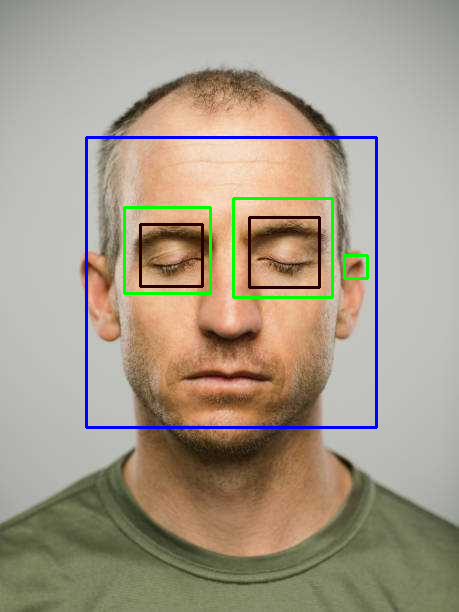

In [30]:
#https://github.com/rk45825243/Face-eye-detection-using-Haar-Cascade-classifier
path2 = base+"edited.jpg"
img = cv.imread(path2)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

face_cascade = cv.CascadeClassifier('/content/drive/MyDrive/cdsaml/haarcasscade/haarcascade_frontalface_alt2.xml')
eye_cascade = cv.CascadeClassifier(r'/content/drive/MyDrive/cdsaml/haarcasscade/haarcascade_eye.xml')
lefteye_cascade = cv.CascadeClassifier('/content/drive/MyDrive/cdsaml/haarcasscade/haarcascade_lefteye_2splits.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)

count_eyes = 0
eyes_open = 1

count_face = len(faces)
face_areas = []
ph,pw,pc = img.shape
pic_area = ph*pw
eye_area = []
pic_mid_point = (pw/2,ph/2)
face_mid_points = []
#print(ph,pw)
for (x, y, w, h) in faces:
    cv.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
    roi_gray = gray[y:y + h, x:x + w]
    roi_color = img[y:y + h, x:x + w]
    face_areas.append(w*h)
    face_mid_points.append((x+w/2,y+h/2))
    #print(h,w)
"""
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex, ey, ew, eh) in eyes:
        cv.rectangle(roi_color, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)
        count_eyes+=1 """

eye = 0
openEye = 0
counter = 0
openEyes = eye_cascade.detectMultiScale(roi_gray)
AllEyes = lefteye_cascade.detectMultiScale(roi_gray)
for (ex, ey, ew, eh) in openEyes:
    openEye += 1
    cv.rectangle(roi_color, (ex, ey), (ex + ew, ey + eh), (0, 255, 0),2)

for (ex, ey, ew, eh) in AllEyes:
    eye += 1
    cv.rectangle(roi_color, (ex, ey), (ex + ew, ey + eh), (0, 0, 40),2)
    count_eyes+=1
    eye_area.append(ew*eh)

if (openEye != eye):
    print ('Eyes Closed')
    eyes_open = 0




eye_area.sort(reverse=True)
cv2_imshow( img)
cv.destroyAllWindows()

# People and Object Detection

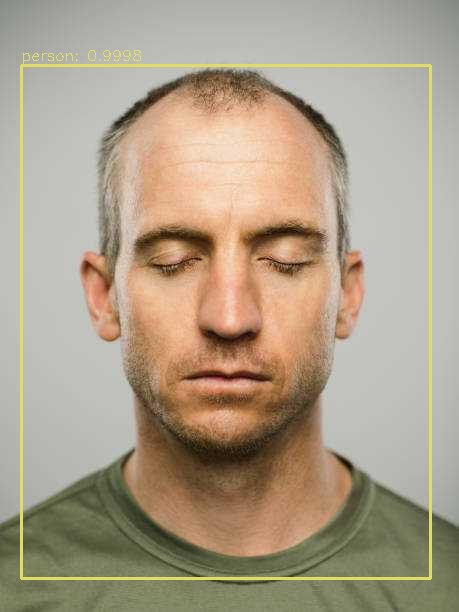

In [31]:
img = cv.imread(path2)
#cv2_imshow(img)
#cv.waitKey(1)

# Load names of classes and get random colors
classes = open('/content/drive/MyDrive/cdsaml/darknet/data/coco.names').read().strip().split('\n')
np.random.seed(42)
colors = np.random.randint(0, 255, size=(len(classes), 3), dtype='uint8')

# Give the configuration and weight files for the model and load the network.
net = cv.dnn.readNetFromDarknet('/content/drive/MyDrive/cdsaml/darknet/cfg/yolov3.cfg', '/content/drive/MyDrive/cdsaml/darknet/yolov3.weights')
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
# net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)

# determine the output layer
ln = net.getLayerNames()
#print(net.getUnconnectedOutLayers())
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# construct a blob from the image
blob = cv.dnn.blobFromImage(img, 1/255.0, (416, 416), swapRB=True, crop=False)
r = blob[0, 0, :, :]

#cv2_imshow( r)
text = f'Blob shape={blob.shape}'
#cv.displayOverlay('blob', text)
#cv.waitKey(1)

net.setInput(blob)
t0 = time.time()
outputs = net.forward(ln)
t = time.time()
#print('time=', t-t0)

#print(len(outputs))
#for out in outputs:
    #print(out.shape)

"""def trackbar2(x):
    confidence = x/100
    r = r0.copy()
    for output in np.vstack(outputs):
        if output[4] > confidence:
            x, y, w, h = output[:4]
            p0 = int((x-w/2)*416), int((y-h/2)*416)
            p1 = int((x+w/2)*416), int((y+h/2)*416)
            cv.rectangle(r, p0, p1, 1, 1)
    #cv.imshow(r)
    text = f'Bbox confidence={confidence}'
    #cv.displayOverlay('blob', text)"""

r0 = blob[0, 0, :, :]
r = r0.copy()
#cv2_imshow( r)
#cv.createTrackbar('confidence', 'blob', 50, 101, trackbar2)
#trackbar2(50)

boxes = []
confidences = []
classIDs = []
h, w = img.shape[:2]

for output in outputs:
    for detection in output:
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]
        if confidence > 0.5:
            box = detection[:4] * np.array([w, h, w, h])
            (centerX, centerY, width, height) = box.astype("int")
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))
            box = [x, y, int(width), int(height)]
            boxes.append(box)
            confidences.append(float(confidence))
            classIDs.append(classID)

indices = cv.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
count_objects = 0
count_person = 0
if len(indices) > 0:
    for i in indices.flatten():
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])
        color = [int(c) for c in colors[classIDs[i]]]
        cv.rectangle(img, (x, y), (x + w, y + h), color, 2)
        text = "{}: {:.4f}".format(classes[classIDs[i]], confidences[i])
        cv.putText(img, text, (x, y - 5), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
        if "person" not in text:
            count_objects += 1
        else:
            count_person += 1

cv2_imshow(img)
cv.waitKey(0)
cv.destroyAllWindows()



# Emotion Detection

[{'box': [122, 127, 227, 318], 'emotions': {'angry': 0.06, 'disgust': 0.0, 'fear': 0.1, 'happy': 0.0, 'sad': 0.4, 'surprise': 0.0, 'neutral': 0.44}}]


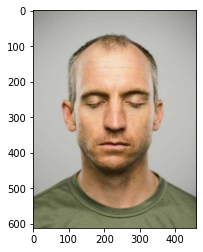

In [32]:
#https://towardsdatascience.com/the-ultimate-guide-to-emotion-recognition-from-facial-expressions-using-python-64e58d4324ff
test_image_one = plt.imread(path2)
emo_detector = FER(mtcnn=True)

# Capture all the emotions on the image
captured_emotions = emo_detector.detect_emotions(test_image_one)

# Print all captured emotions with the image
print(captured_emotions)
plt.imshow(test_image_one)

# Use the top Emotion() function to call for the dominant emotion in the image
dominant_emotion, emotion_score = emo_detector.top_emotion(test_image_one)


In [33]:
print("Total number of objects: ",count_objects)
print("Total number of people: ",count_person)
print("Total number of face: ",count_face)
print("Total number of eyes: ",count_eyes)
print("Image Quality: ",count_quality)
print("Face area ratio: ",max(face_areas)/pic_area)
print("Picture mid point: ",pic_mid_point)
print("Face mid point: ",face_mid_points[face_areas.index(max(face_areas))])
if len(eye_area)>=2:
  print("Eye ratio: ",eye_area[1]/eye_area[0])
print("Emortion: ",dominant_emotion,"(",emotion_score,")")
if eyes_open:
  print("Open Eyes")
else:
  print("Close Eyes")

Total number of objects:  0
Total number of people:  1
Total number of face:  1
Total number of eyes:  2
Image Quality:  38.165671679225255
Face area ratio:  0.29938627593375766
Picture mid point:  (229.5, 306.0)
Face mid point:  (231.0, 282.0)
Eye ratio:  0.7844897959183673
Emortion:  neutral ( 0.44 )
Close Eyes


Eye Contact Detection

In [34]:
import torch.nn as nn
import torch
import math


def model_static(pretrained=False, **kwargs):
    model = ResNet([3, 4, 6, 3], **kwargs)
    if pretrained:
        print('loading saved model weights')
        model_dict = model.state_dict()
        snapshot = torch.load(pretrained)
        snapshot = {k: v for k, v in snapshot.items() if k in model_dict}
        model_dict.update(snapshot)
        model.load_state_dict(model_dict)
    return model


class ResNet(nn.Module):
    def __init__(self, layers):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3,
                               bias = False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer1 = self._make_layer(64, layers[0])
        self.layer2 = self._make_layer(128, layers[1], stride=2)
        self.layer3 = self._make_layer(256, layers[2], stride=2)
        self.layer4 = self._make_layer(512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride = 1)
        self.fc_theta = nn.Linear(512 * Bottleneck.expansion, 34)
        self.fc_phi = nn.Linear(512 * Bottleneck.expansion, 34)
        self.fc_ec = nn.Linear(512 * Bottleneck.expansion, 1)
        self.init_param()

    def init_param(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2./n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.shape[0] * m.weight.shape[1]
                m.weight.data.normal_(0, math.sqrt(2./n))
                m.bias.data.zero_()

    def _make_layer(self, planes, blocks, stride = 1):
        downsample = None
        layers = []

        if stride != 1 or self.inplanes != planes * Bottleneck.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * Bottleneck.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * Bottleneck.expansion),
                )

        layers.append(Bottleneck(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * Bottleneck.expansion
        for i in range(1, blocks):
            layers.append(Bottleneck(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc_ec(x)

        return x


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [35]:
#Eye contact
#https://github.com/rehg-lab/eye-contact-cnn

"""
import dlib
import cv2
import argparse, os, random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import pandas as pd
import numpy as np
#from model import model_static
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
from colour import Color


parser = argparse.ArgumentParser()

parser.add_argument('--video', type=str, help='input video path. live cam is used when not specified')
parser.add_argument('--face', type=str, help='face detection file path. dlib face detector is used when not specified')
parser.add_argument('--model_weight', type=str, help='path to model weights file', default='data/model_weights.pkl')
parser.add_argument('--jitter', type=int, help='jitter bbox n times, and average results', default=0)
parser.add_argument('-save_vis', help='saves output as video', action='store_true')
parser.add_argument('-save_text', help='saves output as text', action='store_true')
parser.add_argument('-display_off', help='do not display frames', action='store_true')

args = parser.parse_args()

CNN_FACE_MODEL = '/content/drive/MyDrive/cdsaml/eye_contact/data' # from http://dlib.net/files/mmod_human_face_detector.dat.bz2


def bbox_jitter(bbox_left, bbox_top, bbox_right, bbox_bottom):
    cx = (bbox_right+bbox_left)/2.0
    cy = (bbox_bottom+bbox_top)/2.0
    scale = random.uniform(0.8, 1.2)
    bbox_right = (bbox_right-cx)*scale + cx
    bbox_left = (bbox_left-cx)*scale + cx
    bbox_top = (bbox_top-cy)*scale + cy
    bbox_bottom = (bbox_bottom-cy)*scale + cy
    return bbox_left, bbox_top, bbox_right, bbox_bottom


def drawrect(drawcontext, xy, outline=None, width=0):
    (x1, y1), (x2, y2) = xy
    points = (x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)
    drawcontext.line(points, fill=outline, width=width)


def run(video_path, face_path, model_weight, jitter, vis, display_off, save_text):
    # set up vis settings

    red = Color("red")
    colors = list(red.range_to(Color("green"),10))
    font = ImageFont.truetype("/content/drive/MyDrive/cdsaml/eye_contact/data/arial.ttf", 40)

    # set up video source
    if video_path is None:
        cap = cv2.VideoCapture(0)
        video_path = 'live.avi'
    else:
        cap = cv2.VideoCapture(video_path)

    # set up output file
    if save_text:
        outtext_name = os.path.basename(video_path).replace('.avi','_output.txt')
        f = open(outtext_name, "w")
    if vis:
        outvis_name = os.path.basename(video_path).replace('.avi','_output.avi')
        imwidth = int(cap.get(3)); imheight = int(cap.get(4))
        outvid = cv2.VideoWriter(outvis_name,cv2.VideoWriter_fourcc('M','J','P','G'), cap.get(5), (imwidth,imheight))

    # set up face detection mode
    if face_path is None:
        facemode = 'DLIB'
    else:
        facemode = 'GIVEN'
        column_names = ['frame', 'left', 'top', 'right', 'bottom']
        df = pd.read_csv(face_path, names=column_names, index_col=0)
        df['left'] -= (df['right']-df['left'])*0.2
        df['right'] += (df['right']-df['left'])*0.2
        df['top'] -= (df['bottom']-df['top'])*0.1
        df['bottom'] += (df['bottom']-df['top'])*0.1
        df['left'] = df['left'].astype('int')
        df['top'] = df['top'].astype('int')
        df['right'] = df['right'].astype('int')
        df['bottom'] = df['bottom'].astype('int')

    if (cap.isOpened()== False):
        print("Error opening video stream or file")
        exit()

    if facemode == 'DLIB':
        cnn_face_detector = dlib.cnn_face_detection_model_v1(CNN_FACE_MODEL)
    frame_cnt = 0

    # set up data transformation
    test_transforms = transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224), transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    # load model weights
    model = model_static(model_weight)
    model_dict = model.state_dict()
    snapshot = torch.load(model_weight)
    model_dict.update(snapshot)
    model.load_state_dict(model_dict)

    model.cuda()
    model.train(False)

    # video reading loop
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret == True:
            height, width, channels = frame.shape
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            frame_cnt += 1
            bbox = []
            if facemode == 'DLIB':
                dets = cnn_face_detector(frame, 1)
                for d in dets:
                    l = d.rect.left()
                    r = d.rect.right()
                    t = d.rect.top()
                    b = d.rect.bottom()
                    # expand a bit
                    l -= (r-l)*0.2
                    r += (r-l)*0.2
                    t -= (b-t)*0.2
                    b += (b-t)*0.2
                    bbox.append([l,t,r,b])
            elif facemode == 'GIVEN':
                if frame_cnt in df.index:
                    bbox.append([df.loc[frame_cnt,'left'],df.loc[frame_cnt,'top'],df.loc[frame_cnt,'right'],df.loc[frame_cnt,'bottom']])

            frame = Image.fromarray(frame)
            for b in bbox:
                face = frame.crop((b))
                img = test_transforms(face)
                img.unsqueeze_(0)
                if jitter > 0:
                    for i in range(jitter):
                        bj_left, bj_top, bj_right, bj_bottom = bbox_jitter(b[0], b[1], b[2], b[3])
                        bj = [bj_left, bj_top, bj_right, bj_bottom]
                        facej = frame.crop((bj))
                        img_jittered = test_transforms(facej)
                        img_jittered.unsqueeze_(0)
                        img = torch.cat([img, img_jittered])

                # forward pass
                output = model(img.cuda())
                if jitter > 0:
                    output = torch.mean(output, 0)
                score = F.sigmoid(output).item()

                coloridx = min(int(round(score*10)),9)
                draw = ImageDraw.Draw(frame)
                drawrect(draw, [(b[0], b[1]), (b[2], b[3])], outline=colors[coloridx].hex, width=5)
                draw.text((b[0],b[3]), str(round(score,2)), fill=(255,255,255,128), font=font)
                if save_text:
                    f.write("%d,%f\n"%(frame_cnt,score))

            if not display_off:
                frame = np.asarray(frame) # convert PIL image back to opencv format for faster display
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                cv2.imshow('',frame)
                if vis:
                    outvid.write(frame)
                key = cv2.waitKey(1) & 0xFF
                if key == ord('q'):
                    break
        else:
            break

    if vis:
        outvid.release()
    if save_text:
        f.close()
    cap.release()
    print ('DONE!')


if __name__ == "__main__":
    run(args.video, args.face, args.model_weight, args.jitter, args.save_vis, args.display_off, args.save_text)

"""

'\nimport dlib\nimport cv2\nimport argparse, os, random\nimport torch\nimport torch.nn as nn\nimport torch.nn.functional as F\nimport torchvision\nfrom torchvision import datasets, transforms\nimport pandas as pd\nimport numpy as np\n#from model import model_static\nfrom PIL import Image\nfrom PIL import ImageDraw\nfrom PIL import ImageFont\nfrom colour import Color\n\n\nparser = argparse.ArgumentParser()\n\nparser.add_argument(\'--video\', type=str, help=\'input video path. live cam is used when not specified\')\nparser.add_argument(\'--face\', type=str, help=\'face detection file path. dlib face detector is used when not specified\')\nparser.add_argument(\'--model_weight\', type=str, help=\'path to model weights file\', default=\'data/model_weights.pkl\')\nparser.add_argument(\'--jitter\', type=int, help=\'jitter bbox n times, and average results\', default=0)\nparser.add_argument(\'-save_vis\', help=\'saves output as video\', action=\'store_true\')\nparser.add_argument(\'-save_text\